In [1]:
import tensorflow as tf
import tensorflow.keras
import tensorflow.keras.backend as k
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorboard.plugins import projector
from tensorflow.keras.layers import Input, Dense, Conv2D, Lambda, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten, Embedding, PReLU, Activation 
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.datasets import mnist
from dataset import laod_dataset, backTonumpy
import os
import io
import random
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
tensorflow.keras.__version__

'2.2.4-tf'

In [3]:
if tf.config.list_physical_devices('GPU'):
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
    tf.config.experimental.set_virtual_device_configuration(physical_devices[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=25000)])

# Load  data

In [4]:
dataset_path = '/home/amir/Desktop/Face-Recognition-and-Verification/Codes/dataset/'
train_dataset, test_dataset  = laod_dataset(dataset_path, mode = 'folder',  batch_size = 128, buffer_size = 1024)

Number of Images: 17534, Number of Labels: 17534
Number of classes: 105.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(79, shape=(), dtype=int32)


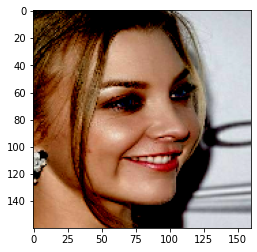

In [5]:
for img, label in train_dataset.take(1):
    plt.imshow(img[0,:,:,:])
    print(label[0])

# Build Model

In [6]:
inputs = Input(shape=(160, 160, 3), name='input')
x = Conv2D(32,kernel_size=3,strides=(1,1),activation='relu', padding='same') (inputs)
x = Conv2D(32,kernel_size=3,strides=(2,2),activation='relu', padding='same') (x)
x = BatchNormalization() (x)
x = Conv2D(64,kernel_size=3,strides=(1,1),activation='relu', padding='same') (x)
x = Conv2D(64,kernel_size=3,strides=(2,2),activation='relu', padding='same') (x)
x = BatchNormalization() (x)
x = Conv2D(128,kernel_size=3,strides=(1,1),activation='relu', padding='same') (x)
x = Conv2D(128,kernel_size=3,strides=(2,2),activation='relu', padding='same') (x)
x = BatchNormalization() (x)
x = Conv2D(256,kernel_size=3,strides=(1,1),activation='relu', padding='same') (x)
x = Conv2D(256,kernel_size=3,strides=(2,2),activation='relu', padding='same') (x)
x = BatchNormalization() (x)
x = GlobalAveragePooling2D() (x)
x = Dense(256) (x)
out1 = PReLU(name='out1') (x)
out2 = Dense(105, activation='softmax')(out1)
model = Model(inputs, out2)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 160, 160, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 160, 160, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 80, 32)        9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 80, 80, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 80, 80, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 40, 40, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 40, 40, 64)        256   

# Create CenterLoss

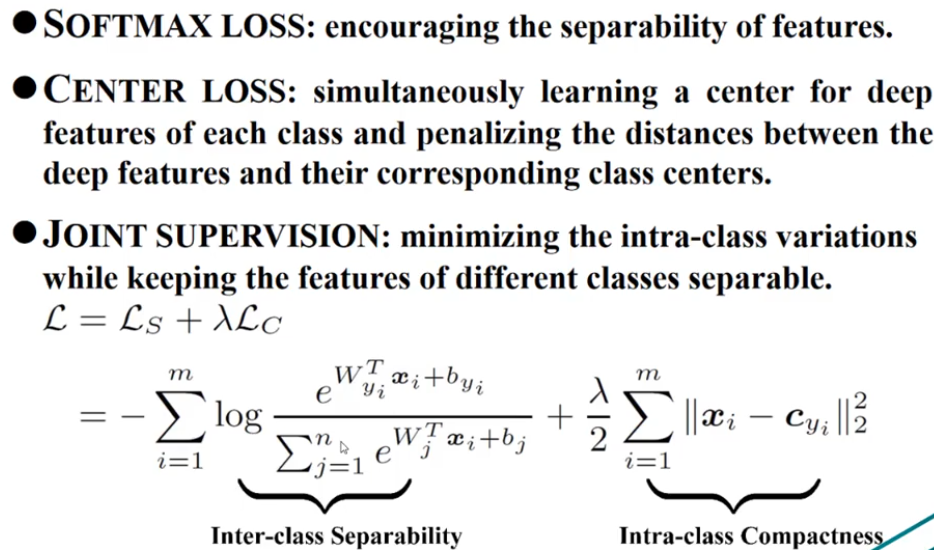

In [7]:
lambda_control = 2
input_ = Input(shape = (1,))
centers = Embedding(105, 256)(input_)
intra_loss = Lambda(lambda x: k.sum(k.square(x[0]-x[1][:,0]),axis = 1, keepdims = True))([out1,centers])

In [8]:
model_center_loss = Model([inputs,input_], [out2,intra_loss])
## the loss calc occurs above , so use a dummy lambda function ((lambda y_true,y_pred:y_pred)) for the loss
model_center_loss.compile(optimizer='adam', loss=['categorical_crossentropy', lambda y_true,y_pred:y_pred],
                         loss_weights=[1, lambda_control/2.],
                         metrics = ['acc'] )

In [9]:
model_center_loss.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 160, 160, 32) 896         input[0][0]                      
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 80, 80, 32)   9248        conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 80, 80, 32)   128         conv2d_1[0][0]                   
____________________________________________________________________________________________

In [10]:
x_train, y_train =  backTonumpy(train_dataset)
x_test, y_test =  backTonumpy(test_dataset)

/home/amir/anaconda3/envs/nlp/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [11]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(16832, 160, 160, 3) (16832,)
(702, 160, 160, 3) (702,)


In [12]:
dummy_matrix1 = np.zeros((x_train.shape[0],1))
dummy_matrix2 = np.zeros((x_test.shape[0],1))
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [13]:
print(dummy_matrix1.shape, y_train_one_hot.shape )

(16832, 1) (16832, 105)


In [14]:
#filepath=".../weights-simple.hdf5" 
#filepath=".../weights-simple.hdf5" 
#checkpointer = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history = model_center_loss.fit(x = [x_train, y_train], y = [y_train_one_hot, dummy_matrix1],
                     batch_size = 64, epochs = 100, verbose = 1, validation_data =([x_test, y_test],[y_test_one_hot, dummy_matrix2]))

Train on 16832 samples, validate on 702 samples
Epoch 1/100
16832/16832 [==============================] - 19s 1ms/sample - loss: 4.7736 - dense_1_loss: 4.6507 - lambda_loss: 0.1229 - dense_1_acc: 0.0109 - lambda_acc: 0.9603 - val_loss: 4.7722 - val_dense_1_loss: 4.6464 - val_lambda_loss: 0.1258 - val_dense_1_acc: 0.0128 - val_lambda_acc: 1.0000
Epoch 2/100
16832/16832 [==============================] - 15s 920us/sample - loss: 4.6433 - dense_1_loss: 4.6430 - lambda_loss: 3.5668e-04 - dense_1_acc: 0.0134 - lambda_acc: 1.0000 - val_loss: 4.6443 - val_dense_1_loss: 4.6416 - val_lambda_loss: 0.0027 - val_dense_1_acc: 0.0157 - val_lambda_acc: 1.0000
Epoch 3/100
16832/16832 [==============================] - 16s 923us/sample - loss: 4.6207 - dense_1_loss: 4.6113 - lambda_loss: 0.0093 - dense_1_acc: 0.0203 - lambda_acc: 1.0000 - val_loss: 5.4165 - val_dense_1_loss: 4.5727 - val_lambda_loss: 0.8445 - val_dense_1_acc: 0.0128 - val_lambda_acc: 0.5997
Epoch 4/100
16832/16832 [===================

Epoch 28/100
16832/16832 [==============================] - 15s 901us/sample - loss: 0.2412 - dense_1_loss: 0.0749 - lambda_loss: 0.1662 - dense_1_acc: 0.9998 - lambda_acc: 0.9922 - val_loss: 4.5563 - val_dense_1_loss: 3.0387 - val_lambda_loss: 1.5133 - val_dense_1_acc: 0.3291 - val_lambda_acc: 0.0969
Epoch 29/100
16832/16832 [==============================] - 15s 901us/sample - loss: 0.2317 - dense_1_loss: 0.0701 - lambda_loss: 0.1616 - dense_1_acc: 0.9998 - lambda_acc: 0.9930 - val_loss: 4.5587 - val_dense_1_loss: 3.0720 - val_lambda_loss: 1.4817 - val_dense_1_acc: 0.3234 - val_lambda_acc: 0.1068
Epoch 30/100
16832/16832 [==============================] - 15s 903us/sample - loss: 0.2175 - dense_1_loss: 0.0644 - lambda_loss: 0.1531 - dense_1_acc: 0.9998 - lambda_acc: 0.9945 - val_loss: 4.3184 - val_dense_1_loss: 2.9333 - val_lambda_loss: 1.3804 - val_dense_1_acc: 0.3462 - val_lambda_acc: 0.1382
Epoch 31/100
16832/16832 [==============================] - 15s 902us/sample - loss: 0.1985

16832/16832 [==============================] - 16s 923us/sample - loss: 0.0664 - dense_1_loss: 0.0149 - lambda_loss: 0.0515 - dense_1_acc: 0.9999 - lambda_acc: 0.9998 - val_loss: 3.4177 - val_dense_1_loss: 2.8401 - val_lambda_loss: 0.5739 - val_dense_1_acc: 0.3561 - val_lambda_acc: 0.5171
Epoch 56/100
16832/16832 [==============================] - 15s 919us/sample - loss: 0.0660 - dense_1_loss: 0.0147 - lambda_loss: 0.0513 - dense_1_acc: 0.9999 - lambda_acc: 0.9997 - val_loss: 3.5686 - val_dense_1_loss: 2.9863 - val_lambda_loss: 0.5784 - val_dense_1_acc: 0.3490 - val_lambda_acc: 0.4858
Epoch 57/100
16832/16832 [==============================] - 15s 918us/sample - loss: 0.0636 - dense_1_loss: 0.0141 - lambda_loss: 0.0494 - dense_1_acc: 0.9999 - lambda_acc: 0.9997 - val_loss: 3.5481 - val_dense_1_loss: 2.9930 - val_lambda_loss: 0.5510 - val_dense_1_acc: 0.3476 - val_lambda_acc: 0.5228
Epoch 58/100
16832/16832 [==============================] - 16s 942us/sample - loss: 0.0558 - dense_1_lo


# Visualizing Data using the Embedding Projector in TensorBoard

Using the TensorBoard Embedding Projector, I can graphically represent high dimensional embeddings. This can be helpful in visualizing, examining, and understanding your embedding layers.


In [15]:
x_test.shape, y_test.shape

((702, 160, 160, 3), (702,))

In [16]:
func = k.function([model.input],[model.get_layer('out1').output])

In [17]:
test_features = func([x_test])
print(test_features[0].shape)

(702, 256)


In [18]:
#calculate center of data
test_centers = np.dot(np.transpose(y_test_one_hot), test_features[0])
test_centers_count = np.sum (np.transpose(y_test_one_hot), axis=1, keepdims=True )
test_centers /= test_centers_count
print(test_centers.shape)

(105, 256)


In [19]:
log_dir = "./logs/%s/" %"CenterLoss"
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

In [20]:
log_dir

'./logs/CenterLoss/'

In [21]:
out_meta = io.open(log_dir+"meta.tsv","w", encoding="utf-8")
for label in y_test:
    out_meta.write(str(label)+'\n')
out_meta.close()

In [22]:
checkpoint =  tf.train.Checkpoint(embedding= tf.Variable(test_features[0]))
checkpoint.save(os.path.join(log_dir,"embedding.ckpt"))

'./logs/CenterLoss/embedding.ckpt-1'

In [27]:
# Set up config
config = projector.ProjectorConfig()
embedding =  config.embeddings.add()
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = "meta.tsv"
projector.visualize_embeddings(log_dir, config)

In [26]:
!kill 6948

In [28]:
%reload_ext tensorboard
%tensorboard --logdir ./logs/CenterLoss/


# Test Model on the Test dataset

In [29]:
def euclidean_distance(vects):
    x,y = vects
    sum_square = k.sum(k.square(x-y), axis=1, keepdims=True)
    sqrt = k.sqrt(k.maximum(sum_square, k.epsilon()))
    return sqrt

In [69]:
num_classes = max(y_test) + 1
digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]

f_idx = random.randint(0, num_classes-1)
pair1 = x_test[random.choice(digit_indices[f_idx])]
pair2 = x_test[random.choice(digit_indices[f_idx])]
pair3 = x_test[random.choice(digit_indices[f_idx+2])]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(160, 160, 3)


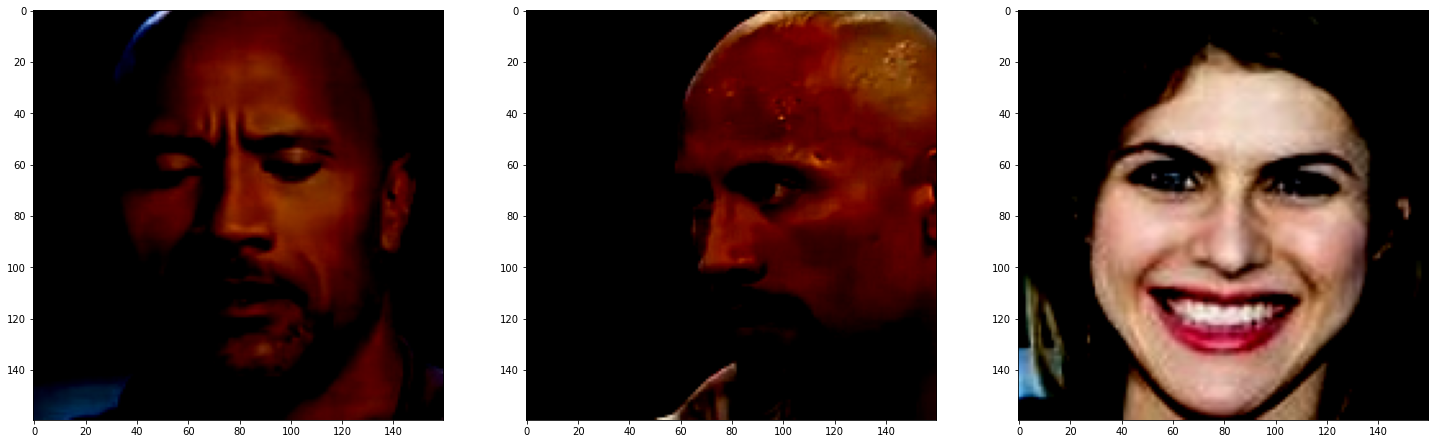

In [70]:
# plot pairs
fig = plt.figure(figsize=(25,25))

plt.subplot(1, 3, 1)
plt.imshow(pair1)

plt.subplot(1, 3, 2)
plt.imshow(pair2)

plt.subplot(1, 3, 3)
plt.imshow(pair3)


print(pair1.shape)

In [71]:
def compare(image1, image2, threshold = 1.04):
    input1 = np.expand_dims(image1,[0])
    input2 = np.expand_dims(image2,[0])
    
    #make prediction
    vec1 = func([input1])
    vec2 = func([input2])
    #check distance
    distance = euclidean_distance([vec1[0], vec2[0]])
    is_same = distance.numpy()[0] < threshold
    print(is_same, 'distance:',distance.numpy()[0])
    print()


In [72]:
compare(pair1, pair2)

[ True] distance: [0.63848186]



In [73]:
compare(pair1, pair3)

[False] distance: [1.4657649]

